In [3]:
%load_ext autoreload
%autoreload 2
import bnl
from bnl import fio, mtr, viz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
fio.adobe_hiers(776)

{'mu1_gamma1': <bnl.core.H at 0x1237f2ee0>,
 'mu5_gamma5': <bnl.core.H at 0x1236adc40>,
 'mu1_gamma9': <bnl.core.H at 0x123462c40>}

In [48]:
# Now. I want to find and set up the new metric and reason through it on some of these examples
refs, ests = fio.salami_annos(776)

## Now how do my I define recall between ref_rated_boundaries and est_rated_boundaries?

1) I take all the boundary keys in the ref_rated boundaries, 
2) see how much est_rated_boundary can recover: hit rate, and count inversions of pair ranks.

So we only need to look at all the potential boundaries in ref_rated_boundaries.

In [59]:
import mir_eval, librosa
import numpy as np
from scipy import stats
import bnl
from collections import Counter

In [ ]:
# Let's do match event first, and get indicator vector of whether each ref bs of any depth is recalled at all:
def b_rank_recall(ref_bs, ref_sal, est_bs, est_sal, window=0.5):
    hits = mir_eval.util.match_events(ref_bs, est_bs, window=window)
    est_sal_at_ref_bs = np.zeros(len(ref_bs))
    for ref_index, est_index in hits:
        # if it's a hit, get the salience of that boundary in est_sal
        est_sal_at_ref_bs[ref_index] = est_sal[est_index] + 1
    # print(est_sal_at_ref_bs)

    # Now we have two lists, let's just count inversions in ranking
    inversions, total_pairs = mir_eval.hierarchy._compare_frame_rankings(
        np.array(ref_sal), np.array(est_sal_at_ref_bs), transitive=True
    )
    recall = 1 - (inversions / total_pairs)
    return recall

def bmeasure(ref_itvls, est_itvls, window=0.5, beta=1.0, force_mono=False):
    # Get the salience
    ref_bs, ref_sal = boundary_salience(ref_itvls, force_mono=False)
    est_bs, est_sal = boundary_salience(est_itvls, force_mono=force_mono)
    
    # Get the scores
    recall = b_rank_recall(ref_bs, ref_sal, est_bs, est_sal, window=window)
    precision = b_rank_recall(est_bs, est_sal, ref_bs, ref_sal, window=window)
    f_measure = mir_eval.util.f_measure(precision, recall, beta=beta)
    return precision, recall, f_measure


def boundary_salience(hier_itvls, force_mono=False, sorted=False):
    hier = bnl.H(hier_itvls)
    # cast to mono accoringly
    if force_mono and not hier.has_mono_B():
        if force_mono == 'naive':
            hier = hier.force_mono_B(min_seg_dur=1)
        elif force_mono == 'bsc':
            if hier.sr is None or hier.Bhat_bw is None:
                hier.update_sr(10)
                hier.update_bw(1)
            hier = hier.decode_B()

    hier.plot()
    # use counter to accumulate boundary counts, which in the monotnoic case will be salience
    counter = Counter()
    for lvl in hier.levels:
        counter.update(lvl.beta)
    # return the items and counts of the counter object as two arrays
    boundaries = np.array(list(counter.keys()))
    salience = np.array(list(counter.values()))
    # sort the boundaries and salience
    if sorted:
        # sort them by boundaries
        sorted_indices = np.argsort(boundaries)
        boundaries = boundaries[sorted_indices]
        salience = salience[sorted_indices]
    return boundaries, salience


(0.6104651162790697, 0.6234567901234568, 0.6168925600604968)

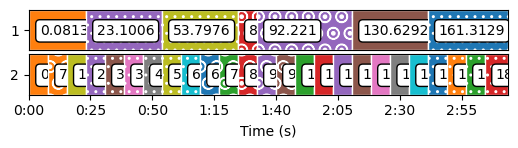

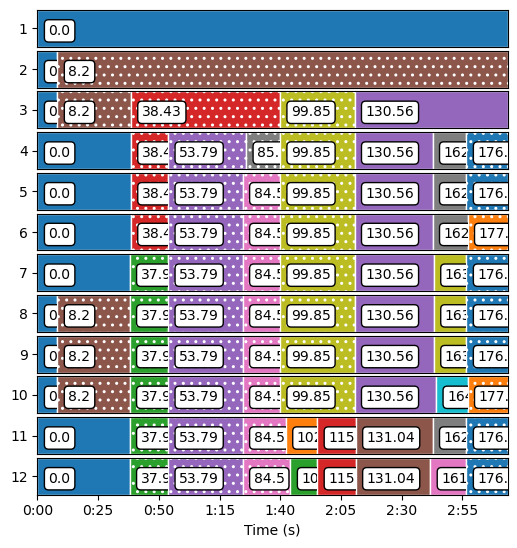

In [142]:
bmeasure(refs['4'].itvls, ests['mu5_gamma5'].itvls, window=0.5, beta=1.0)

(0.574468085106383, 0.48765432098765427, 0.5275132929392853)

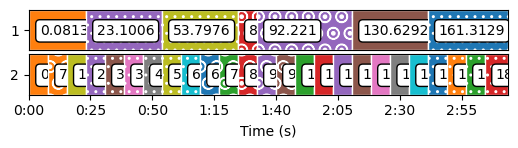

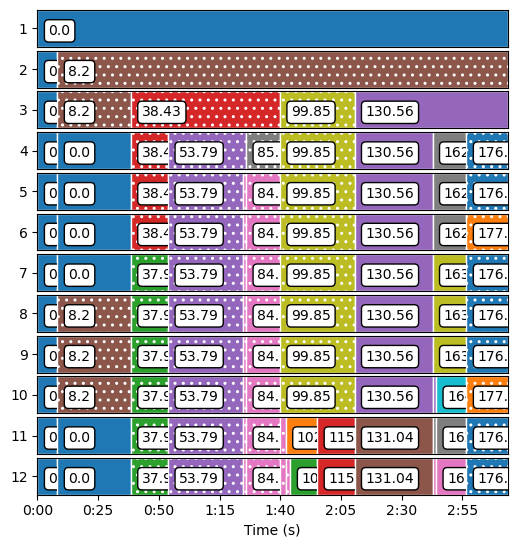

In [143]:
bmeasure(refs['4'].itvls, ests['mu5_gamma5'].itvls, window=0.5, beta=1.0, force_mono='naive')

(0.46153846153846156, 0.49382716049382713, 0.47713717693836977)

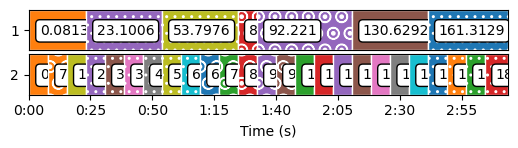

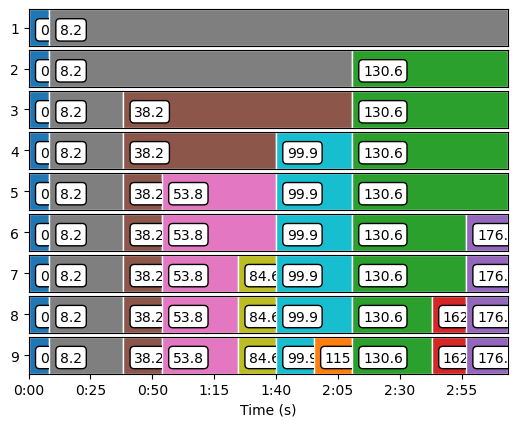

In [144]:
bmeasure(refs['4'].itvls, ests['mu5_gamma5'].itvls, window=0.5, beta=1.0, force_mono='bsc')